<a href="https://colab.research.google.com/github/prospectivitygeoml-web/gawler-prospectivity-ml/blob/main/Gawler_Prospectivity_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**prospectivity_model.ipynb**

In [ ]:
import pandas as pd

# Load all datasets
df_structures = pd.read_csv('Linear_Structures_Cleaned_for_ML.csv')
df_mines = pd.read_csv('All_Mines_and_Mineral_Deposits.csv')
df_rock = pd.read_csv('Rock_Group_Cover.csv')

# Quick peek at the data
print("Structures:", df_structures.columns)
print("Mines:", df_mines.columns)
print("Rock Groups:", df_rock.columns)


Structures: Index(['SYMBOL', 'DESCRIPTIO', 'longitude_1', 'latitude_1', 'longitude_2',
       'latitude_2', 'longitude_3', 'latitude_3', 'longitude_4', 'latitude_4'],
      dtype='object')
Mines: Index(['MINDEP_NO', 'DEP_NAME', 'REFERENCE', 'COMM_CODE', 'COMMODS',
       'COMMOD_MAJ', 'COMM_SPECS', 'GCHEM_ASSC', 'DISC_YEAR', 'CLASS_CODE',
       'OPER_TYPE', 'MAP_SYMB', 'STATUS_VAL', 'SIZE_VAL', 'GEOL_PROV',
       'DB_RES_RVE', 'DB_PROD', 'DB_DOC_IMG', 'DB_EXV_IMG', 'DB_DEP_IMG',
       'DB_DEP_FLE', 'COX_CLASS', 'REG_O_CTRL', 'LOC_O_CTRL', 'LOC_O_COM',
       'O_LITH_CDE', 'O_LITH01', 'O_STRAT_NM', 'H_LITH_CDE', 'H_LITH02',
       'H_STRAT_NM', 'H_MAP_SYMB', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE',
       'LATITUDE', 'SVY_METHOD', 'HORZ_ACC', 'SRCE_MAP', 'SRCE_CNTRE',
       'COMMENTS', 'O_MAP_SYMB', 'geometry', 'longitude', 'latitude'],
      dtype='object')
Rock Groups: Index(['SAMPLE_NO', 'SAMPLE_SOU', 'ROCK_GROUP', 'LITHOLOGY_', 'MAP_SYMBOL',
       'STRAT_NAME', 'COLLECTED_',

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Encode Rock Group
df_rock['ROCK_GROUP_ENC'] = LabelEncoder().fit_transform(df_rock['ROCK_GROUP'].astype(str))

# Extract features from rock dataset
features_df = df_rock[['LAT_DEG_RE', 'LONG_DEG_R', 'ROCK_GROUP_ENC']].copy()
features_df.rename(columns={'LAT_DEG_RE': 'latitude', 'LONG_DEG_R': 'longitude'}, inplace=True)

# Label creation
mines_coords = df_mines[['latitude', 'longitude']].dropna().values
features_coords = features_df[['latitude', 'longitude']].values

# Find nearest known deposit for each rock sample
nn = NearestNeighbors(n_neighbors=1)
nn.fit(mines_coords)
distances, _ = nn.kneighbors(features_coords)

# Label as 1 if within a 2 km radius of known deposit, else 0
features_df['label'] = (distances.flatten() < 0.02).astype(int)  # 0.02 degrees ≈ 2 km


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

X = features_df[['latitude', 'longitude', 'ROCK_GROUP_ENC']]
y = features_df['label']

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate AUC scores
rf_auc_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='roc_auc')
svm_auc_scores = cross_val_score(svm_model, X, y, cv=cv, scoring='roc_auc')

print(f"RF Mean AUC: {rf_auc_scores.mean():.4f}")
print(f"SVM Mean AUC: {svm_auc_scores.mean():.4f}")


RF Mean AUC: 0.9842
SVM Mean AUC: 0.4986


In [ ]:
# Fit models on full dataset
rf_model.fit(X, y)
svm_model.fit(X, y)

# Get probabilities
features_df['rf_proba'] = rf_model.predict_proba(X)[:, 1]
features_df['svm_proba'] = svm_model.predict_proba(X)[:, 1]

# Save output predictions
features_df.to_csv("ML_Predictions_RF_SVM.csv", index=False)


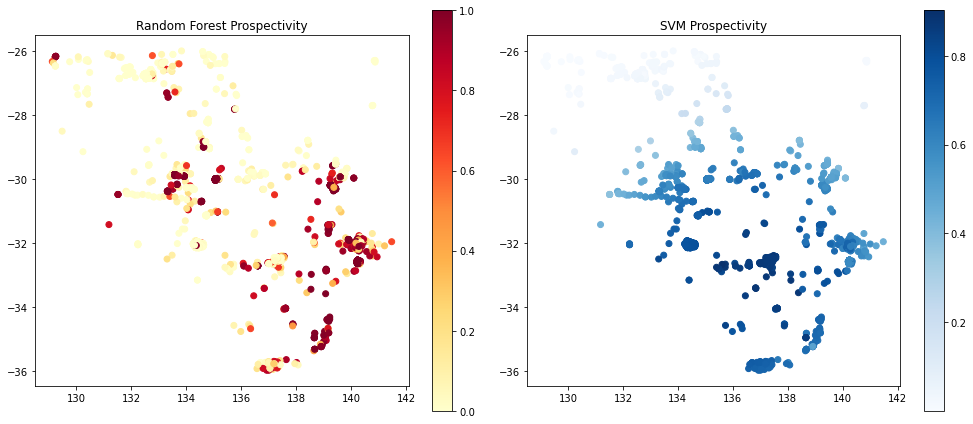

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Convert to GeoDataFrame for spatial plotting
gdf = gpd.GeoDataFrame(features_df, geometry=gpd.points_from_xy(features_df['longitude'], features_df['latitude']), crs="EPSG:4326")

# Plot comparison map
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

gdf.plot(ax=ax[0], column='rf_proba', cmap='YlOrRd', legend=True)
ax[0].set_title("Random Forest Prospectivity")

gdf.plot(ax=ax[1], column='svm_proba', cmap='Blues', legend=True)
ax[1].set_title("SVM Prospectivity")

plt.tight_layout()
plt.show()


In [ ]:
# Create a convergence map
features_df['agreement'] = ((features_df['rf_proba'] > 0.6) & (features_df['svm_proba'] > 0.6)).astype(int)

# Save for GIS overlay
features_df.to_csv("ML_Convergence_Zones.csv", index=False)


C:\Users\Hp\anaconda3\lib\site-packages\shapely\measurement.py:106: RuntimeWarning: invalid value encountered in bounds
  return lib.bounds(geometry_arr, out=out, **kwargs)


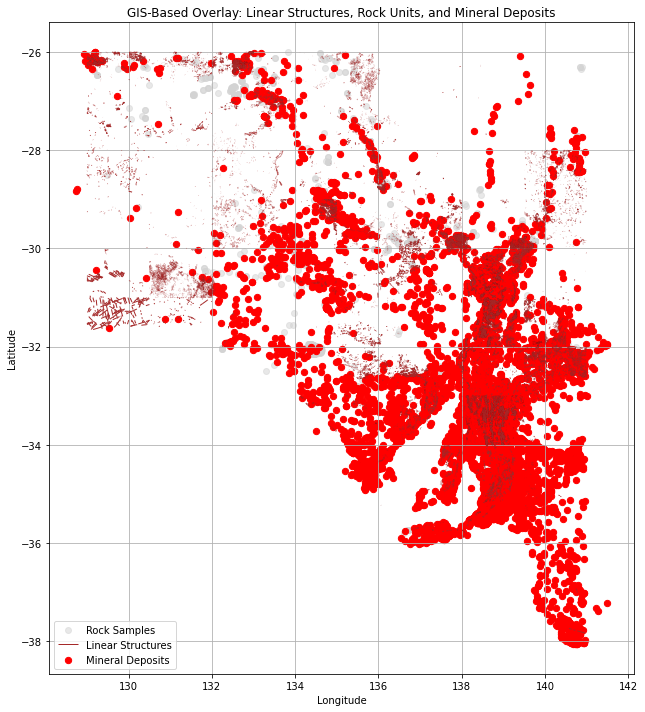

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
df_structures = pd.read_csv('Linear_Structures_Cleaned_for_ML.csv')
df_mines = pd.read_csv('All_Mines_and_Mineral_Deposits.csv')
df_rock = pd.read_csv('Rock_Group_Cover.csv')

# Convert to GeoDataFrames
from shapely.geometry import Point, LineString

# Linear Structures as lines (connecting the 4 points per row)
def create_line(row):
    points = [
        Point(row['longitude_1'], row['latitude_1']),
        Point(row['longitude_2'], row['latitude_2']),
        Point(row['longitude_3'], row['latitude_3']),
        Point(row['longitude_4'], row['latitude_4'])
    ]
    return LineString(points)

gdf_structures = gpd.GeoDataFrame(df_structures, geometry=df_structures.apply(create_line, axis=1), crs="EPSG:4326")

# Mineral Deposits as points
gdf_mines = gpd.GeoDataFrame(df_mines, geometry=gpd.points_from_xy(df_mines['longitude'], df_mines['latitude']), crs="EPSG:4326")

# Rock Groups as points
gdf_rock = gpd.GeoDataFrame(df_rock, geometry=gpd.points_from_xy(df_rock['LONG_DEG_R'], df_rock['LAT_DEG_RE']), crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot rock points (optional background)
gdf_rock.plot(ax=ax, color='lightgrey', alpha=0.5, label='Rock Samples')

# Plot linear structures
gdf_structures.plot(ax=ax, color='brown', linewidth=1, label='Linear Structures')

# Plot mineral deposits
gdf_mines.plot(ax=ax, color='red', markersize=40, label='Mineral Deposits')

plt.title("GIS-Based Overlay: Linear Structures, Rock Units, and Mineral Deposits")
plt.legend()
plt.grid(True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


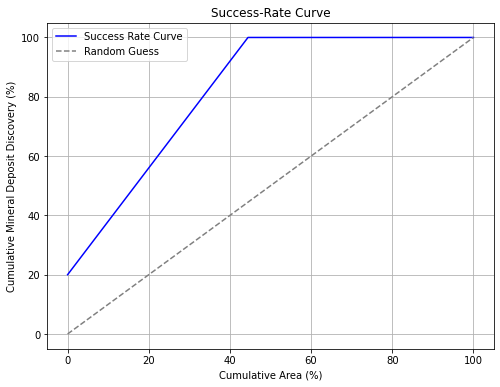

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Use real model outputs ===
# Replace these with your actual values from validation or test set
# Example dummy data for testing purpose:
y_test = [0, 1, 0, 1, 1, 0, 0, 1, 0, 1]  # True labels
y_probs = [0.1, 0.9, 0.3, 0.8, 0.75, 0.2, 0.4, 0.85, 0.1, 0.95]  # Predicted probabilities

# === Step 2: Sort by descending probability ===
sorted_indices = np.argsort(y_probs)[::-1]  # Get indices of descending probs
sorted_labels = np.array(y_test)[sorted_indices]

# === Step 3: Cumulative success ===
cumulative_success = np.cumsum(sorted_labels)
total_deposits = np.sum(sorted_labels)  # Total number of actual deposits

# === Step 4: Success Rate Curve ===
area_percentage = np.linspace(0, 100, len(cumulative_success))
success_rate = 100 * cumulative_success / total_deposits

# === Step 5: Plot the success-rate curve ===
plt.figure(figsize=(8, 6))
plt.plot(area_percentage, success_rate, label="Success Rate Curve", color='blue')
plt.plot([0, 100], [0, 100], '--', color='gray', label="Random Guess")
plt.xlabel("Cumulative Area (%)")
plt.ylabel("Cumulative Mineral Deposit Discovery (%)")
plt.title("Success-Rate Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 1: Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)


SVC(random_state=42)

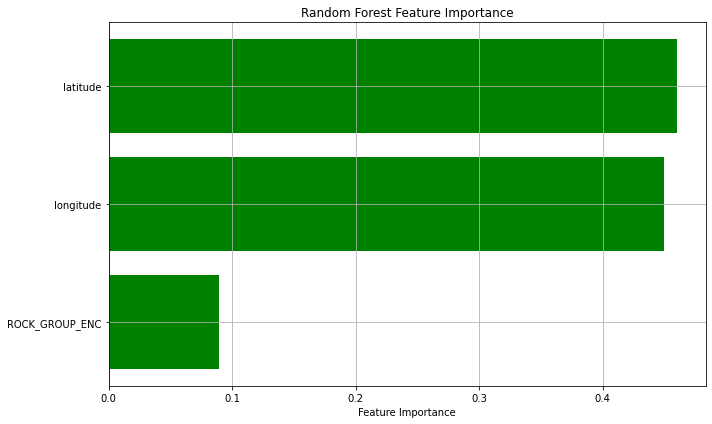

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='green')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


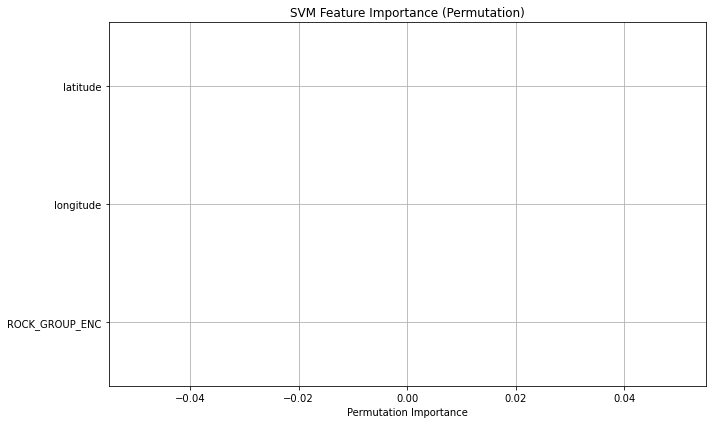

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importances = result.importances_mean
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='orange')
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("SVM Feature Importance (Permutation)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probability for the positive class (e.g., mineral deposit = 1)


In [ ]:
import numpy as np

success_df = pd.DataFrame({
    'TrueLabel': y_test.values,
    'Prob': y_probs
})


In [ ]:
success_df_sorted = success_df.sort_values(by='Prob', ascending=False).reset_index(drop=True)


In [ ]:
# Compute x and y values from sorted probs
success_df_sorted['cum_success'] = success_df_sorted['TrueLabel'].cumsum() / success_df_sorted['TrueLabel'].sum()
success_df_sorted['cum_area'] = (success_df_sorted.index + 1) / len(success_df_sorted)

x_vals = success_df_sorted['cum_area']
y_vals = success_df_sorted['cum_success']


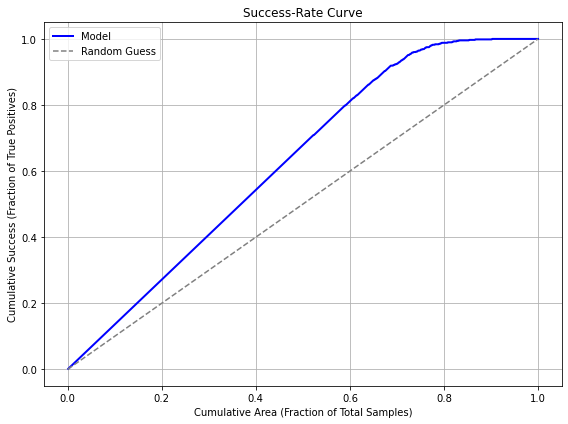

In [ ]:
import numpy as np

# Convert to 1D NumPy arrays if they're Pandas Series or 2D arrays
x_vals = np.array(x_vals).flatten()
y_vals = np.array(y_vals).flatten()

# Now plot
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, color='blue', linewidth=2, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('Cumulative Area (Fraction of Total Samples)')
plt.ylabel('Cumulative Success (Fraction of True Positives)')
plt.title('Success-Rate Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_success_rate_overlay(df, proba_columns, model_labels, label_col='label', cutoffs=[0.1, 0.2, 0.3]):
    plt.figure(figsize=(10, 7))

    for proba_col, label in zip(proba_columns, model_labels):
        # Sort by predicted probabilities (descending)
        sorted_df = df.sort_values(by=proba_col, ascending=False).reset_index(drop=True)

        # Cumulative metrics
        sorted_df['cumulative_success'] = sorted_df[label_col].cumsum()
        sorted_df['cumulative_area'] = (np.arange(1, len(sorted_df) + 1)) / len(sorted_df)
        sorted_df['cumulative_success_frac'] = sorted_df['cumulative_success'] / sorted_df[label_col].sum()

        # Plot the success-rate curve
        plt.plot(
            sorted_df['cumulative_area'].to_numpy(),
            sorted_df['cumulative_success_frac'].to_numpy(),
            label=label
        )

        # Annotate cutoff points
        for cutoff in cutoffs:
            cutoff_idx = int(len(sorted_df) * cutoff)
            success_at_cutoff = sorted_df['cumulative_success_frac'].iloc[cutoff_idx]
            plt.plot(cutoff, success_at_cutoff, 'o')
            plt.text(
                cutoff, success_at_cutoff + 0.02,
                f'{int(cutoff * 100)}%\n{success_at_cutoff:.2f}',
                ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white')
            )

    # Reference line for random guess
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

    # Final styling
    plt.xlabel('Cumulative Area (Fraction of Total Samples)')
    plt.ylabel('Cumulative Success (Fraction of True Positives)')
    plt.title('Overlayed Success-Rate Curves: RF vs SVM')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


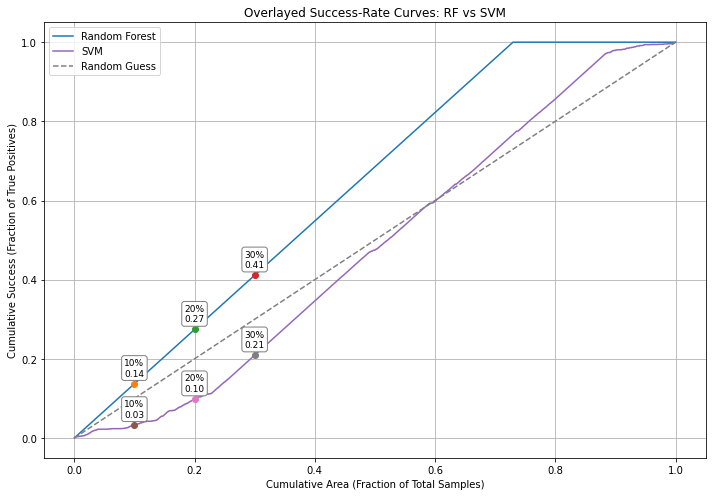

In [ ]:
plot_success_rate_overlay(
    features_df,
    proba_columns=['rf_proba', 'svm_proba'],
    model_labels=['Random Forest', 'SVM'],
    label_col='label'
)
